# WaterTAP Academy Week 3 Hands-On Tutorial  
## Techno-Economic Analysis and Cost Optimization of an RO with ERD Flowsheet

In this week’s hands-on tutorial, we will use WaterTAP to perform a Techno-Economic Analysis (TEA) on the flowsheet shown below: a single-stage Reverse Osmosis (RO) system equipped with an Energy Recovery Device (ERD). This example builds directly on the Week 2 after-session assignment.

<center><img src="./graphics/RO_with_ERD.png" width="600" /></center>

In the previous tutorial, we introduced how to add costing blocks on top of individual unit models for TEA. Now we will extend those concepts to the **flowsheet level**, demonstrating how performance modeling, costing, and optimization come together for system-wide analysis.

---

## In this tutorial, we will work through the following parts:

**Part 1 – Develop Process Model**  
- Build the RO flowsheet and set up a full process simulation for performance prediction.

**Part 2 – Develop TEA Model**  
- Integrate WaterTAP’s costing framework to complete the TEA model.  
- Compute key economic and energy metrics, such as Levelized Cost of Water (LCOW) 
- Plot and interpret system performance and cost results.

**Part 3 – Optimization Study for Cost Minimization**  
- Modify the model to set up and solve an optimization problem aiming to minimize LCOW.  
- Review the resulting optimal operating conditions.

**Part 4 – Try It Yourself: Build Your Optimization and Visualize Results**  
- Modify the model assumptions and create visualizations for your optimization study.





---

## **Part 1 – Develop Process Model** 

In this part, we will build a predictive process model of the RO flowsheet with ERD.
All steps and code used here were covered in the previous session, so this section serves as a quick review of how to construct a working flowsheet simulation before moving on to TEA and optimization.

1. **Import Required Modules**  
2. **Create the Process Model**  
3. **Solve the Model**  
4. **Check the Model Prediction**

---


### **1.1 Import Required Modules**
Import all WaterTAP, Pyomo, and helper modules needed for building and solving the RO flowsheet.


In [1]:
# Imports from Pyomo
from pyomo.environ import (
    ConcreteModel,
    Var,
    Param,
    Constraint,
    Objective,
    value,
    assert_optimal_termination,
    TransformationFactory,
    units as pyunits,
)
from pyomo.network import Arc

# Imports from IDAES
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Product
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor
from idaes.core.util.initialization import propagate_state

# Imports from WaterTAP
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock
from watertap.unit_models.pressure_changer import Pump
from watertap.unit_models.pressure_changer import EnergyRecoveryDevice
from watertap.unit_models.reverse_osmosis_0D import (
    ReverseOsmosis0D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.core.solvers import get_solver


### **1.2 Create the Process Model**

<center><img src="./graphics/RO_with_ERD.png" width="600" /></center>

- Define the main Pyomo model using **`ConcreteModel()`**.  
- Build the WaterTAP flowsheet using **`FlowsheetBlock()`**.  
- Define the water chemistry using **`SeawaterParameterBlock()`**, which provides the property package for the RO system.  
- Add the required unit models, including:  
  - `Feed()`  
  - `Pump()`  
  - `ReverseOsmosis0D()`  
  - `EnergyRecoveryDevice()`  
  - `Product()`  
- Connect the units using process streams (via **`Arc`**) to form the complete flowsheet.




In [2]:
# Create a model object using ConcreteModel
m = ConcreteModel()
# Add the flowsheet to the model using FlowsheetBlock
m.fs = FlowsheetBlock(dynamic=False)
# Add the Seawater property package
m.fs.properties = SeawaterParameterBlock()

In [3]:
# Add feed
m.fs.feed = Feed(property_package=m.fs.properties)
# Set feed stream
m.fs.feed.properties[0].flow_vol_phase["Liq"].fix(1e-3)
m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "TDS"].fix(35)
m.fs.feed.properties[0].pressure.fix(101325)
m.fs.feed.properties[0].temperature.fix(273.15 + 25)


# Add pump
m.fs.pump = Pump(property_package=m.fs.properties)
# Set pump parameters
m.fs.pump.efficiency_pump.fix(0.80)
m.fs.pump.control_volume.properties_out[0].pressure.fix(75 * pyunits.bar)


# Add 0D reverse osmosis unit
m.fs.RO = ReverseOsmosis0D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
)
# Set RO parameters
m.fs.RO.A_comp.fix(4.2e-12)
m.fs.RO.B_comp.fix(3.5e-8)
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.5)
m.fs.RO.feed_side.channel_height.fix(1e-3)
m.fs.RO.feed_side.spacer_porosity.fix(0.97)
m.fs.RO.permeate.pressure[0].fix(101325)
m.fs.RO.area.fix(50)

# Add Energy Recovery Device
m.fs.erd = EnergyRecoveryDevice(property_package=m.fs.properties)
# Set ERD parameters
m.fs.erd.efficiency_pump.fix(0.95)
m.fs.erd.outlet.pressure[0].fix(101325)

# Add product stream
m.fs.product = Product(property_package=m.fs.properties)

In [4]:
# Define the connectivity using Arcs
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
m.fs.pump_to_RO = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
m.fs.RO_to_erd = Arc(source=m.fs.RO.retentate, destination=m.fs.erd.inlet)
m.fs.RO_to_product = Arc(source=m.fs.RO.permeate, destination=m.fs.product.inlet)

# Use the TransformationFactory to expand the arcs
TransformationFactory("network.expand_arcs").apply_to(m)

### **1.3 Solve the Model**
- Apply appropriate scaling factors for model stability.  
- Initialize each unit model to provide good starting guesses.  
- Solve the full flowsheet using a nonlinear solver to obtain predictive model results.

In [5]:
# Set Scaling factors
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1, index=("Liq", "H2O"))
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1e2, index=("Liq", "TDS"))
set_scaling_factor(m.fs.pump.control_volume.work, 1e-3)
set_scaling_factor(m.fs.RO.area, 1e-2)
calculate_scaling_factors(m)

2025-12-05 10:54:49 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.erd.control_volume.work


In [6]:
# Get WaterTAP solver
solver = get_solver()
solver.solve(m.fs.feed)
# Propagate state from feed to pump
propagate_state(m.fs.feed_to_pump)
# Initialize pump
m.fs.pump.initialize()
# Propagate state from pump to RO
propagate_state(m.fs.pump_to_RO)
# Initialize RO
m.fs.RO.initialize()
# Propagate state from RO to ERD and product
propagate_state(m.fs.RO_to_erd)
propagate_state(m.fs.RO_to_product)
# Initialize the product and ERD
m.fs.product.initialize()
m.fs.erd.initialize()

2025-12-05 10:54:51 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2025-12-05 10:54:51 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
2025-12-05 10:54:51 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2025-12-05 10:54:51 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2025-12-05 10:54:52 [INFO] idaes.init.fs.RO.feed_side.properties_out: fs.RO.feed_side.properties_out State Released.
2025-12-05 10:54:52 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2025-12-05 10:54:52 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2025-12-05 10:54:53 [INFO] idaes.init.fs.RO.permeate_side: fs.RO.permeate_side State R

In [7]:
print("DOF = ", degrees_of_freedom(m))
# Solve the model and assert the the model has reached optimal termination
results = solver.solve(m, tee=False)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

DOF =  0
Solver Status: ok, Termination Condition: optimal


### **1.4 Check the Model Prediction**
- Inspect key output variables such as flows, pressures, recovery, and concentrations.  
- Verify that the model behavior is physically reasonable before proceeding.

In [8]:
# Report unit-level performance results for (1) the pump, (2) RO and (3) the energy recovery device, using the report() method for each unit on the flowsheet.
m.fs.pump.report()
m.fs.RO.report()
m.fs.erd.report()


Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Units         : Fixed : Bounds
         Efficiency :    0.80000 : dimensionless :  True : (None, None)
    Mechanical Work :     9248.3 :          watt : False : (None, None)
    Pressure Change : 7.3987e+06 :        pascal : False : (None, None)
     Pressure Ratio :     74.019 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units           Inlet     Outlet  
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second    0.98796    0.98796
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second   0.035000   0.035000
    temperature                                     kelvin     298.15     298.15
    press

---

## **Part 2 – Develop TEA Model**

In this part, we will use WaterTAP costing functionality to develop a complete TEA model.The steps are needed:

1. Import Required Modules and build TEA Model   
2. Add system level metrics
3. Solve TEA Model and Print Key Metrics
4. Display LCOW breakdown (as needed)



---

### **2.1 Import Required Modules and Build TEA Model**

- Add a **costing block** for the overall flowsheet using `WaterTAPCosting()`.  
- Add **costing add-ons** to individual unit models using `UnitModelCostingBlock()`
- Process the costing information

In [9]:
# Import costing package
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

# Add costing
m.fs.costing = WaterTAPCosting()
m.fs.costing.base_currency = pyunits.USD_2020

m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.RO.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.erd.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)

# Process costing
m.fs.costing.cost_process()

2025-12-05 10:54:56 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.


### **2.2 Add System-level Metrics** 

The system-level metrics we are interested in — and that are built into WaterTAP — are:

- **Annual water production**
- **Levelized Cost of Water (LCOW)**
- **Specific Energy Consumption (SEC)**


In [10]:
# Add Annual water production
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)

# Levelized Cost of Water (LCOW)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)

# Specific Energy Consumption (SEC)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)

### **2.3 Solve the TEA Model and Print Key Metrics**

In [11]:
# Initialize costing
m.fs.costing.initialize()

# ReSolve the model and assert the the model has reached optimal termination
results = solver.solve(m, tee=False)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

# Display key metrics : LCOW
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

# Display key metrics : SEC
print(
    "Specific energy consumption: %.1f kWh/m3"
    % value(m.fs.costing.specific_energy_consumption)
)

# Display other metrics
print("Total operating cost: %.4g $/yr" % value(m.fs.costing.total_operating_cost))
print("Total capital cost: %.4g $" % value(m.fs.costing.total_capital_cost))
print("Total annualized cost: %.4g $/yr" % value(m.fs.costing.total_annualized_cost))

Solver Status: ok, Termination Condition: optimal
Levelized cost of water: 0.61 $/m3
Specific energy consumption: 3.3 kWh/m3
Total operating cost: 4756 $/yr
Total capital cost: 3.976e+04 $
Total annualized cost: 8732 $/yr


### **2.4 Display LCOW Breakdown (as needed)**

In [12]:
from utility_functions import get_break_down_values, table_view

simulation_results = get_break_down_values(m)
table_view(simulation_results)

-----------------------------
| Cost Breakdown | Value ($/m³) |
-----------------------------
| Pump CAPEX     |      0.123 |
| RO CAPEX       |      0.010 |
| ERD CAPEX      |      0.007 |
| Indirect CAPEX |      0.140 |
| RO OPEX        |      0.027 |
| Electricity    |      0.230 |
| Other OPEX     |      0.078 |
-----------------------------
| TOTAL LCOW     |      0.615 |
-----------------------------


## **Part 3 – Optimization Study for Cost Minimization**

In this part, we will set up and solve an optimization problem to minimize the Levelized Cost of Water (LCOW).  
The optimization problem aims to identify the optimal **RO operating area** and **feed pressure** to achieve the lowest LCOW.  
There are constraints on **minimum water flux** and **maximum product water salinity** to ensure feasible and practical operation.  

The optimization study will be conducted in the following four steps:

1. Free decision variables in Pump and RO  
2. Add process requirements (e.g., product water salinity and minimum water flux)  
3. Add objective function to minimize LCOW  
4. Solve the Optimization Problem and Display the Optimal Solution
5. Visualize LCOW Results Comparison


### **3.1 Free Decision Variables**

In [13]:
# Unfix decision variables - pump
m.fs.pump.control_volume.properties_out[0].pressure.unfix()
m.fs.pump.control_volume.properties_out[0].pressure.setlb(10e5)
m.fs.pump.control_volume.properties_out[0].pressure.setub(85e5)
m.fs.pump.deltaP.setlb(0)

# Unfix decision variables - RO
m.fs.RO.area.unfix()
m.fs.RO.area.setlb(1)
m.fs.RO.area.setub(1500)

### **3.2 Add Process Requirements**

In [14]:
# Add extra process requirement constraints
m.fs.product_salinity = Param(
    initialize=500e-6, mutable=True
)  # product NaCl mass fraction [-]
m.fs.minimum_water_flux = Param(
    initialize=1.0 / 3600.0, mutable=True
)  # minimum water flux [kg/m2-s]
m.fs.eq_product_quality = Constraint(
    expr=m.fs.product.properties[0].mass_frac_phase_comp["Liq", "TDS"]
    <= m.fs.product_salinity
)
m.fs.eq_minimum_water_flux = Constraint(
    expr=m.fs.RO.flux_mass_phase_comp[0, 1, "Liq", "H2O"] >= m.fs.minimum_water_flux
)

### **3.3 Add Objective Function**

In [15]:
# Add objective function
m.fs.objective = Objective(expr=m.fs.costing.LCOW)

### **3.4 Solve the Optimization Problem and Display the Optimal Solution**

In [16]:
# Solve the optimization
results = solver.solve(m, tee=False)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

# Display decision variables
print("Optimal operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print("Optimal membrane area %.1f m2" % (m.fs.RO.area.value))

# Display LCOW metrics
print("Optimal LCOW: %.2f $/m3" % value(m.fs.costing.LCOW))

Solver Status: ok, Termination Condition: optimal
Optimal operating pressure 50.0 bar
Optimal membrane area 132.3 m2
Optimal LCOW: 0.50 $/m3


### **3.5 Visualize LCOW Results Comparison**

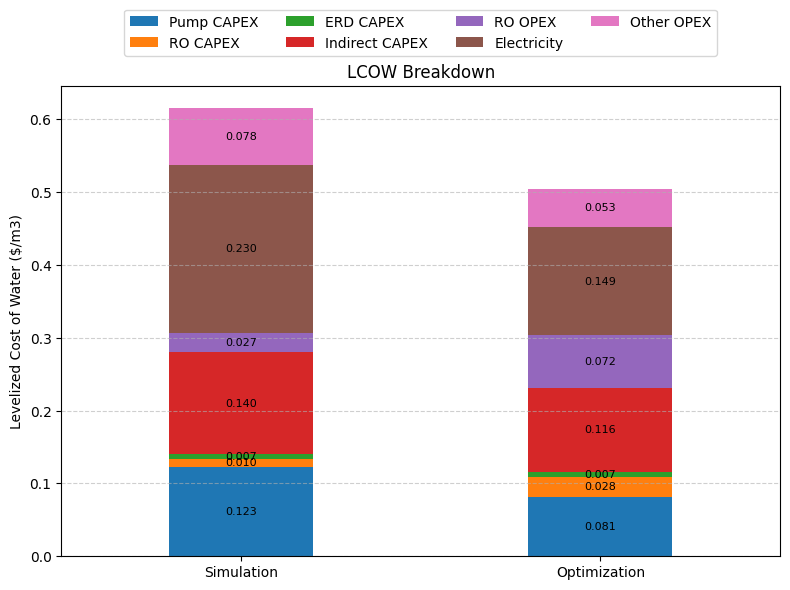

In [17]:
from utility_functions import visualize_breakdown

# get breakdown value for optimization results
optimization_results = get_break_down_values(m)

# Add  breakdown resutls to breakdown_data_dict
breakdown_data_dict = {}
breakdown_data_dict["Simulation"] = simulation_results
breakdown_data_dict["Optimization"] = optimization_results


# Generate a comparison plot of LCOW contributions
visualize_breakdown(breakdown_data_dict)

## **Part 4 – Try It Yourself: Build Your Optimization and Visualize Results**

### **Build Your Optimization Task: modify the RO costing assumptions**
Before doing that, let’s quickly review what we learned in the previous tutorial about the costing assumptions we added and where they are defined.

In [18]:
# Display RO costing assumptions
m.fs.costing.reverse_osmosis.display()

Block fs.costing.reverse_osmosis

  Variables:
    factor_membrane_replacement : Membrane replacement factor [fraction of membrane replaced/year]
        Size=1, Index=None, Units=1/a
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   0.2 :  None :  True :  True :  Reals
    membrane_cost : Membrane cost
        Size=1, Index=None, Units=USD_2018/m**2
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :    30 :  None :  True :  True :  Reals
    high_pressure_membrane_cost : Membrane cost
        Size=1, Index=None, Units=USD_2018/m**2
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :    75 :  None :  True :  True :  Reals

  Objectives:
    None

  Constraints:
    None


### **Change the RO membrane cost assumptions to $50/\text{m}^2$**

<details>
  <summary>Click the arrow for Solutions!</summary>

`m.fs.costing.reverse_osmosis.membrane_cost.fix(50)`

</details>

In [19]:
m.fs.costing.reverse_osmosis.membrane_cost.fix(50)


### **Solve the new optimization problem and display the LCOW**


<details>
  <summary>Click the arrow for Solutions!</summary>

`results = solver.solve(m, tee=False)`

`print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))`

</details>

In [20]:
results = solver.solve(m, tee=False)
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

Levelized cost of water: 0.58 $/m3


### **Collect LCOW Breakdown Values and Plot**
- Pass the model to the function `get_break_down_values()`. This function returns a dictionary with detailed LCOW breakdown values.  
- Add the optimization breakdown to the `breakdown_data_dict` dictionary.  
- Pass this dictionary to the function `visualize_breakdown()` to generate a comparison plot of LCOW contributions.


<details>
  <summary>Click the arrow for Solutions!</summary>
    
`my_case_results = get_break_down_values(m)`

`breakdown_data_dict ["My Case"] = my_case_results`

`visualize_breakdown(breakdown_data_dict)`



</details>

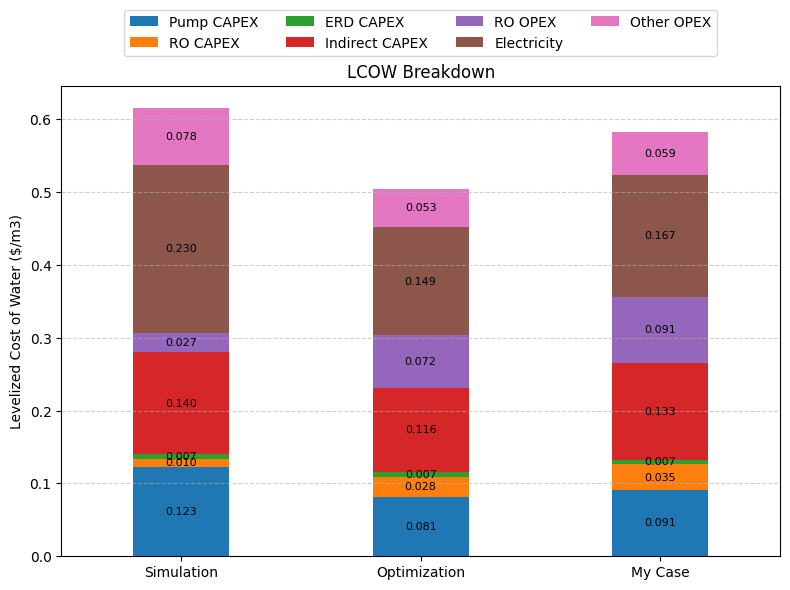

In [21]:
my_case_results = get_break_down_values(m)

breakdown_data_dict["My Case"] = my_case_results

visualize_breakdown(breakdown_data_dict)